### Generation of series on Artificial Market and calculation of Fitness

#### Methods on artificial market

In [66]:
import matplotlib.pyplot as plt
import networkx as nx
import random as rnd
import numpy as np
import collections
%matplotlib inline

N = 500  # number of agent
p_sell =0.4
p_buy =0.4
num_play = 365*3


class Agent:
    def  __init__(self,id):
        self.id = id
        self.choice = None
        self.strategy = None # hold
        self.buy = p_buy
        self.sell = p_sell
def  init_decision():
    random.seed(None)
    for focal in agent_list:
        r = rnd.random()
        if 0<= r<focal.buy:
            focal.choice = 'buy'
            focal.strategy = 1
        elif focal.buy<=r<=focal.buy+focal.sell:
            focal.choice = 'sell'
            focal.strategy = -1
        else: 
            focal.choice = 'hold'
            focal.strategy= 0
            
agent_list = [Agent(id) for id in range(N)]

def count():
    delta = sum(list(map(lambda agent:agent.strategy, agent_list)))
    return delta

def find_hub():
    degree_sequence = sorted([d for n, d in G.degree().items()])
    degreeCount = collections.Counter(degree_sequence)
    #calculate path lenght to the nearest influencer and inflencer node. 
    par = 0.7 # upper 100*(1-par)%  
    hub = [n for n, d in G.degree().items() if d>max(degreeCount.keys())*par]
    return hub

def find_influencer(G, hub):
    inf = []
    length = []
    store = [] # [influencer node, path length to influencer]
    isolates = nx.isolates(G)
    l1 = []
    l2 = []
    # find nodes which have no path to hub, then store in sub  
    sub=[] 
    for n in range(N):
        ns = nx.node_connected_component(G,n)
        if not ns & set(hub):sub.append(n)    

    tmp = []
    for n in G.degree().keys():
        if n in hub or n in isolates or n in sub:
            store.append([n,0])
        else:
            for h in hub:
                try:
                    tmp.append(nx.shortest_path_length(G,n,h))
                except:
                    pass
            mi = min(tmp)
            store.append([hub[tmp.index(mi)], mi])
            tmp.clear()
    num = [i for i in range(N)]
    #di = dict(zip(num,store)) # di = {node num:[nearest influencer, path length to nearest influencer]}
    influencers = [s[0] for s in store]
    lengths = [s[1] for s in store]
    return influencers, lengths

def update_strategy(agent_list, influencers, lengths):
    for focal, i,l in zip(agent_list, influencers,lengths):
        r = rnd.random()
        p = 1-0.1*l
        if 0<=r<p:
            focal.strategy  =  agent_list[i].strategy

def graph_to_gene(G):
    mat = nx.to_numpy_array(G)
    gene = []
    for i in range(N-1):
        tmp = mat[i,i+1:]
        gene.extend(tmp)
    return gene

def gene_to_graph(gene):
    mat = np.zeros((N,N))
    loc = 0
    for i in range(0,N):
        mat[i,i+1:]  = gene[loc:loc+(N-i-1)]
        loc +=N-i-1
    mat  = mat+ mat.T
    G = nx.from_numpy_matrix(mat)
    return G

def generate_graph(N):
    G  =nx.gnp_random_graph(N,0.2)
    gene = graph_to_gene(G)
    return gene

def extract_influencers(G):
    PCT = 0.05 #choose as influencer from upper "pct" of degree centrality
    degree_centers = nx.degree_centrality(G)
    degree_list = sorted(degree_centers.items(), key=lambda x: x[1], reverse=True)
    influencers = [agent_list[degree_list[i][0]] for i in range(len(G))][0:int(len(G)*PCT)]
    return influencers

#### Modeling herding behavior (diffusion) by Independent Cascade Model 

In [67]:
def IC_model_diffusion(G, diffusion_probability):
    random.seed(None)
    DPROB = diffusion_probability     #拡散確率
    init_decision()
    influencers = extract_influencers(G)
    influencers_list = [i.id for i in influencers]   
#     print("init decision",[agent_list[i].choice for i in range(len(G))])
#     print("influencer",influencers_list)
#     print ("influencer's choice",[agent_list[i].choice for i in influencers_list])


    informed = []
    informed.extend(influencers_list) # 始めにインフルエンサーを格納しておく
    state = "ongoing" # state is "ongoing" or "end". if "ongoing" difussion go next step otherewise finish.

    while state == "ongoing":
        state = "end"

        # opinions の中にインフルエンサーによる決断の影響を格納
        opinions = [{"buy":0,"sell":0,"hold":0} for i in range(len(G))] # reset opinions
        #print("inf list",[i.id for i in influencers])
        for infl in influencers:
            for focal in G.neighbors(infl.id) :
                opinions[focal][infl.choice] +=1 
        influencers = [] # reset
        #print("opinion",opinions)

        for focal in agent_list:
            if focal.id not in informed:
                i = focal.id
                if opinions[i]['sell']!=0 or opinions[i]['buy']!=0 or opinions[i]['hold']!=0:
                    r = rnd.random()
                    if 0< r < DPROB: # 同調する場合
                        buy_p = opinions[i]['buy'] /(opinions[i]['sell']+opinions[i]['buy']+ opinions[i]['hold'])
                        sell_p = opinions[i]['sell'] /(opinions[i]['sell']+opinions[i]['buy']+ opinions[i]['hold'])
                        hold_p = opinions[i]['hold'] /(opinions[i]['sell']+opinions[i]['buy']+ opinions[i]['hold'])
                        if 0<= r<buy_p:
                            focal.choice = 'buy'
                            focal.strategy = 1
                        elif buy_p<=r<=buy_p+sell_p:
                            focal.choice = 'sell'
                            focal.strategy = -1
                        else: 
                            focal.choice = 'hold'
                            focal.strategy= 0
                    state = "ongoing" # 次の拡散へ続く
                    informed.append(i)
                    influencers.append(agent_list[i])
#     print([i.choice for i in agent_list])
    return count()

#### Generation of Series on Artificial Market

In [68]:
def priceSeries(G): 
    price = 0
    prices = [price]
    delta_series = []
    # generate first 500 steps series by random walk  for calculating R(t)
#     for i in range(500):
#         init_decision()
#         delta = count()
#         price+=delta
#         delta_series.append(delta)

    # use IC model after 500 steps   
    for play in range(num_play):
        delta = IC_model_diffusion(G,1)
        price +=delta
        prices.append(price)
        delta_series.append(delta)

#draw price movement
#     plt.plot(prices, label="price")
#     plt.title("Simulation Result")
#     plt.ylabel("price")
#     plt.xlabel("time step")
#     plt.grid("on")
#     plt.legend()
#     plt.show()
#     print (transform_into_gene(G))
    return prices, delta_series

#### Evaluation Function (kutosis(original series)，in ±σ,out ±3σ(return series), autocorrelation(differencing series, LAG=1))

In [75]:
import datetime 
import pandas as pd 
import pandas_datareader.data as web
import scipy.stats as sp
import numpy as np

def evaluate(individual):
    # statistics of SP500
    kuto = 5.0
    sig1 = 0.79
    sig3 = 0.056
    autocorr = 0.291
    
    G1 = gene_to_graph(individual)
    _,x = priceSeries(G1)
    x = np.array(x)
    # kutosis
    kutosis = sp.kurtosis(x)
    
    # sigma
#     tmp  =pd.Series(prices).pct_change()
#     df  =pd.DataFrame(tmp)
#     df = df.replace(-np.inf,np.nan).replace(np.inf,np.nan).dropna()
#     x = df.ix[:,0]
    in_1sigma = len([i for i in x if np.average(x)-np.std(x)<i<np.average(x)+np.std(x)])/len(x)
    out_3sigma = len([i for i in x if i<np.average(x)-np.std(x)*2 or i>np.average(x)+np.std(x)*2])/len(x)
    a = np.round(abs(kuto -kutosis),4)
    b = np.round(abs(sig1-in_1sigma),4)
    c = np.round(abs(sig3-out_3sigma),4)
    
    # autocorrelation(LAG = 1)
    LAG = 1
    diff = x**2
    diff_mean = np.mean(diff) 
    corr = np.sum((diff[LAG:] - diff_mean)*(diff[:-LAG] - diff_mean))  / np.sum((diff - diff_mean)**2) 
    d = np.round(abs(corr-autocorr),4)
    return a,b,c,d

#### Optimization by multi-objective GA (NSGA-2) (main method)

In [78]:
import array
import random

import numpy

from math import sqrt

from deap import algorithms
from deap import base
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
import copy 


creator.create("FitnessMaX", base.Fitness, weights=(-1.0,-1.0,-1.0,-1.0))
creator.create("IndividuaL", list, fitness=creator.FitnessMaX)

toolbox  = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, int(1/2*N*(N-1)))
toolbox.register("individual", tools.initRepeat, creator.IndividuaL, toolbox.attr_bool, int(1/2*N*(N-1)))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("evaluate",evaluate,)


def main(seed=None):
    random.seed(seed)

    NGEN = 20
    CXPB = 0.8
    MU = 20

    stats = tools.Statistics(lambda ind: ind.fitness.values) #  argument of stats is poplation. 
    stats.register("avg", numpy.mean, axis=0)
#     stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "min", "avg", "max"  # does "evals" need??
    
    pop = toolbox.population(n=MU)
    pop_first = copy.deepcopy(pop)
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))

    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    # Begin the generational process
    for gen in range(1, NGEN):
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)
            
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)


    #print("Final population hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))

    return pop_first ,pop, logbook 


In [74]:
if __name__ == "__main__":
    pop0,pop, logbook= main()
    

### Simulation result

In [152]:
# generate graph from pop

def pop_to_graph(pop):
    g = []
    for i in range(20): # MU =20
        g.append(gene_to_graph(pop[i]))
    return g
g0 = pop_to_graph(pop0)
g = pop_to_graph(pop)

#### looks of graph

In [153]:
def draw_graph(g):
    fig,ax = plt.subplots(5,4,figsize = (20,16))
    loc = 0
    for i in range(5):
        for j in range(4):
            nx.draw(g[loc],ax = ax[i,j],alpha=0.7)
            loc +=1

In [155]:
# draw_graph(g)

#### Degree histgram

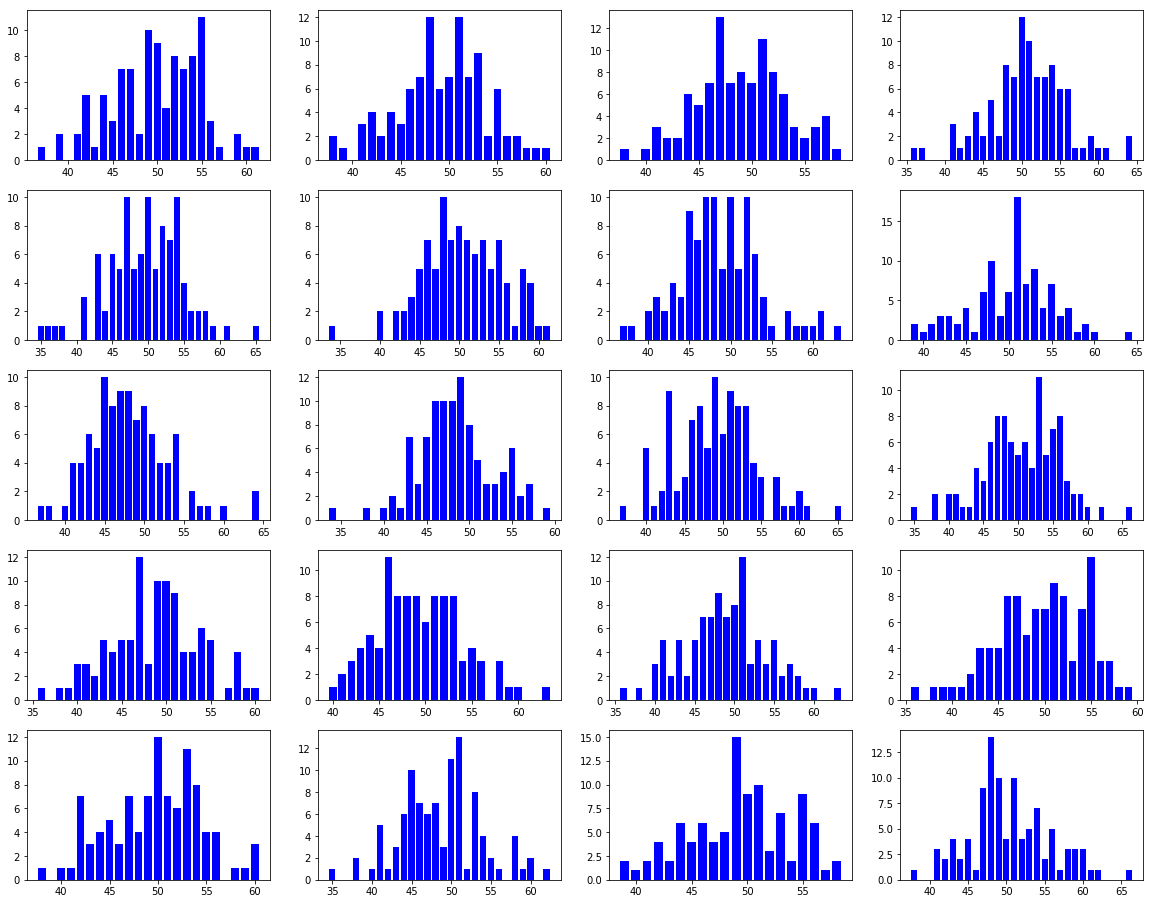

In [157]:
import collections
def draw_degree_hist(g):
    fig,ax = plt.subplots(5,4,figsize = (20,16))
    loc = 0
    for i in range(5):
        for j in range(4):
            degree_sequence = sorted([d for n, d in g[loc].degree()], reverse=True)
            degreeCount = collections.Counter(degree_sequence)
            deg, cnt = zip(*degreeCount.items())
            ax[i,j].bar(deg, cnt, width=0.80, color='b')
            loc +=1
    plt.show()
draw_degree_hist(g0)

#### Average degree

In [159]:
def ave_degree(g):
    av =[]
    for i in range(len(g)):
        av.extend([d for n, d in g[i].degree()])
    degree_ave = np.average(av)
    return degree_ave
print("first_pop:",ave_degree(g0))
print("final_pop:",ave_degree(g))

first_pop: 49.417
final_pop: 49.446
